# Redes Neuronales
## TP1

Entrene una red de Hopfield ‘82 con las imágenes binarias disponibles en el campus.
1. Verifique si la red aprendió las imágenes enseñadas.
2. Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes aprendidas: agregado de ruido, elementos borrados o agregados.
3. Evalúe la existencia de estados espurios en la red: patrones inversos y combinaciones de un número impar de patrones. (Ver Spurious States, en la sección 2.2, Hertz, Krogh & Palmer, pág. 24).
4. Realice un entrenamiento con las 6 imágenes disponibles. ¿Es capaz la red de aprender todas las imágenes? Explique.

### Inciso 1

Lo primero que voy a hacer es importar las bibliotecas básicas para poder desarrollar el ejercicio. 

In [3]:
# primero importamos numpy y algo para leer imágenes y hacer graficos
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Para las imágenes opté la manera fácil de usarlas locales, pero no sería difícil descargarlas desde gitHub en runtime y usarlas de ahí. Para los incisos 1, 2 y 3 separé las imágenes en 2 grupos porque son de diferentes tamaños. El cuarto se hace con las 6 imágenes con alguna modificación a los tamaños. 

In [2]:
# necesito paths a las imagenes,vienen de un repo clonado localmente 
path1 = 'imagenes_tp1\\paloma.bmp'
path2 = 'imagenes_tp1\\panda.bmp' # 50*50
path3 = 'imagenes_tp1\\perro.bmp' #50*50
path4= 'imagenes_tp1\\quijote.bmp'
path5= 'imagenes_tp1\\torero.bmp'
path6= 'imagenes_tp1\\v.bmp' #50*50


Creo una función que toma una lista de paths a las imágenes y devuelve las imágenes en forma de vectores columna concatenadas. 

In [5]:
def imgPath_to_vector(paths):
    """Toma una lista de paths y genera:
       - Matriz (pixeles x imágenes), cada columna es una imagen
       - Lista de imágenes como vectores (en [-1,1])
       - Forma original (alto, ancho)
    """
    vectores = []
    forma = None
    for path in paths:
        img = Image.open(path).convert("L")  # escala de grises (mejor)
        vector_img = np.array(img).astype(np.int8)
        forma = vector_img.shape          # guardamos una sola vez
        vector_img = vector_img.ravel()
        vectores.append(vector_img * 2 - 1)  # (0,1) -> (-1,1)
    return np.array(vectores).T, forma

flattened_images1, forma1 = imgPath_to_vector([path2, path3, path6])
flattened_images2, forma2 = imgPath_to_vector([path1, path4, path5])

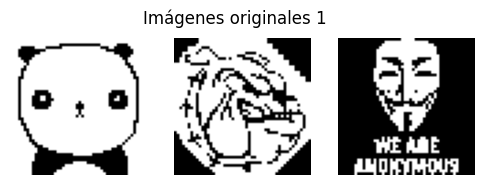

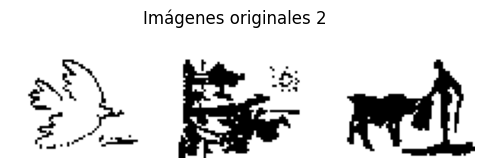

In [13]:
# ahora mostramos las imagenes originales
def mostrar_imagenes(imagenes, forma, titulo):
    """Muestra una lista de imágenes (vectores) en una fila"""
    num_imgs = imagenes.shape[1]
    plt.figure(figsize=(num_imgs * 2, 2))
    for i in range(num_imgs):
        plt.subplot(1, num_imgs, i + 1)
        plt.imshow((1 - (imagenes[:, i].reshape(forma) + 1) / 2), cmap='gray')
        plt.axis('off')
    plt.suptitle(titulo)
    plt.show()

mostrar_imagenes(flattened_images1, forma1, "Imágenes originales 1")
mostrar_imagenes(flattened_images2, forma2, "Imágenes originales 2")

Arriba se pueden ver las imágenes originales separadas por tamaño. 

Ahora bien, la altura de los vectores columna que contienen las imágenes (nuestras "realizaciones" para el contexto de lo que buscamos que aprendan las neuonas) nos da la cantidad de neuronas y, por ende, el tamaño de la matriz $W$ de pesos de interconexión de neuronas. Como se discutió en clase, la diagonal de $W$ son ceros para que las nueronas no se realimenten a si mismas. 

Para este primer caso, el factor de aprendizaje $\eta$ se mantiene unitario, no afecta al aprendizaje. 

La matriz $W$ se compone de diferentes $w_{i,j}$, inicializados en cero (van de -1 a 1) y actualizados según la regla:
$$
\Delta {w_{i,j}}_{n} = \eta \cdot  p^1 _i \cdot p^1 _j
$$
$$
{w_{i,j} }_{n+1} = {w_{i,j}}_{n} + \Delta {w_{i,j}}_{n}
$$

Dónde $p^1 _i$ es el pattern\patrón en la iteración 1 y posición i. 

La matriz se calcula por medio de un producto matricial entre los vectores columna de datos con ellos mismos. 

In [14]:
# ahora sabemos que hay tantas neuronas como valores en los vectores columna que conforman la matriz de datos "flattened_images1"
# W es una matriz cuadrada de filas y columnas de igual tamaño a la cantidad de neuronas

def calcular_matriz_W(patrones,eta=1):
    X = np.asmatrix(patrones.astype(np.float64))
    W_matrix = eta * X @ X.T
    np.fill_diagonal(W_matrix, 0) # le saco la diagona,lo de diag(diag) está en lapágina de numpy
    return W_matrix

Ahora calculo la matriz de pesos para el primer set de imágenes/patrones. Con este, podemos ver la evolución de la red neuronal partiendo del patrón que se quiera. Para el primer inciso se le alimentan los mismos patrones y se revisa que no cambie entre iteraciones singulares, indicando que son mínimos en la función que representa los estados posibles de la red. En otras palabras, si no cambia es porque se aprendió el patrón. 

In [15]:
W_matrix1 = calcular_matriz_W(flattened_images1)
W_matrix2 = calcular_matriz_W(flattened_images2)

In [26]:
def correr_red(W, patron):
    """
    Avanza la red de Hopfield desde un patrón inicial.

    W: matriz de pesos (n_pixeles x n_pixeles)
    patron: vector columna inicial (n_pixeles,) o (n_pixeles,1)
    iters: cantidad de iteraciones

    Devuelve: estado final después de iters pasos
    """
    estado = patron.copy()
    estado = W @ estado.T
    estado = np.where(estado>=0,1,-1) # la regla vista en clase, manteniendo todo en -1 y 1
    return estado

In [30]:
a = flattened_images1[:, 0].copy()  # primera imagen
b  = correr_red(W_matrix1, a)
b

array([[-1, -1, -1, ..., -1, -1, -1]])

In [174]:
def chequear_aprendizaje(W_matrix, patron_inicial, originales, iters=5):
    columnas = patron_inicial.shape[1]
    lista_recordada = []

    for i in range(columnas):
        original_i = originales[:, i]
        estado = patron_inicial[:, i].copy()
        proceso_reconstruccion = []

        for n in range(iters):
            estado = correr_red(W_matrix, estado, iters=1)
            proceso_reconstruccion.append(estado.copy())

        lista_recordada.append(proceso_reconstruccion)

        if np.array_equal(original_i, proceso_reconstruccion[-1]):
            print(f"La imagen {i} fue recordada correctamente.")
        else:
            print(f"La imagen {i} NO fue recordada correctamente.")

    return lista_recordada


In [ ]:
a = np.asarray(correr_red(W_matrix1,flattened_images1[:,0],1))
a

matrix([[-1., -1., -1., ..., -1., -1., -1.]])

### Resultados del inciso 1

Con todas las funciones ya definidas revisamos que las redes hayan aprendido.

In [176]:
lista_recordada1 = chequear_aprendizaje(W_matrix1,flattened_images1,flattened_images1,iters=1)

La imagen 0 NO fue recordada correctamente.
La imagen 1 NO fue recordada correctamente.
La imagen 2 NO fue recordada correctamente.


In [177]:
lista_recordada2 = chequear_aprendizaje(W_matrix2, flattened_images2,flattened_images2)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2700)

Se observa que ambas redes entrenadas aprendieron los patrones/imágenes. Abajo se muestran comparaciones de laas imágenes reales y las aprendidas. En este caso son idénticas, pero no lo va a ser para el segundo inciso. 

In [ ]:
def mostrar_resultados(memoria, imagenes, forma):
    alto, ancho = forma
    n_imagenes = imagenes.shape[1]

    plt.figure(figsize=(2*n_imagenes, 4))

    for i in range(n_imagenes):
        # Original
        plt.subplot(2, n_imagenes, i+1)
        plt.imshow((imagenes[:, i] + 1)/2 .reshape(alto, ancho), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Originales')

        # Después de iterar
        plt.subplot(2, n_imagenes, i+1+n_imagenes)
        plt.imshow((np.array(memoria[i]).ravel() + 1)/2 .reshape(alto, ancho), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Convergidas')

    plt.tight_layout()
    plt.show()


AttributeError: 'int' object has no attribute 'reshape'

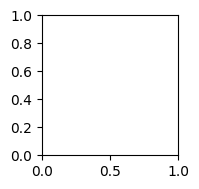

In [ ]:
mostrar_resultados(lista_recordada1, flattened_images1,forma1)

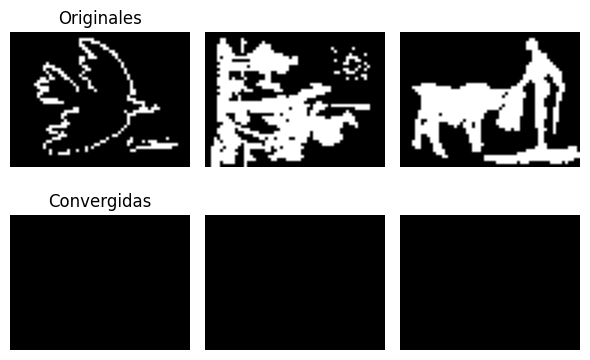

In [ ]:
mostrar_resultados(lista_recordada2 ,flattened_images2,forma2)

### Inciso 2

Ahora voy a cargar unas fotos editadas a mano, con elemenos quitados y agregados. La idea es ver si la red converge a la imagen original partiendo de la editada, lo que indicaría que fueron aprendidas. Ahora incluyo las imágenes nuevas. 

In [ ]:
# necesito paths a las imagenes,vienen de un repo clonado localmente 
path7 = 'imagenes_tp1\\paloma.bmp'
path8 = 'imagenes_tp1\\panda.bmp' # 50*50
path9 = 'imagenes_tp1\\perro.bmp' #50*50
path10= 'imagenes_tp1\\quijote.bmp'
path11= 'imagenes_tp1\\torero.bmp'
path12= 'imagenes_tp1\\v.bmp' #50*50

flattened_images1_editadas, lista_img1_editadas,forma1_editadas = imgPath_to_vector([path8,path9,path12]) # tenemos las imagenes 
flattened_images2_editadas, lista_img_editadas,forma2_editadas = imgPath_to_vector([path7,path10,path11])